0.9932 accuracy per iteration
0.9987 accuracy per iteration
0.9997 accuracy per iteration
0.999 accuracy per iteration
0.9994 accuracy per iteration
0.9996 accuracy per iteration
0.9997 accuracy per iteration
0.9995 accuracy per iteration
1.0 accuracy per iteration
0.9995999599959996 accuracy per iteration
Accuracy: 0.5618
[SPLIT 1]
Accuracy: 0.9988
[SPLIT 2]
Accuracy: 0.9988
[SPLIT 3]
Accuracy: 0.9988
[SPLIT 4]
Accuracy: 0.9988
[SPLIT 5]
Accuracy: 0.9988
[SPLIT 6]
Accuracy: 0.9988
[SPLIT 7]
Accuracy: 0.9988
[SPLIT 8]
Accuracy: 0.9988
[SPLIT 9]
[[19976     0]
 [   24     0]]
0.9988


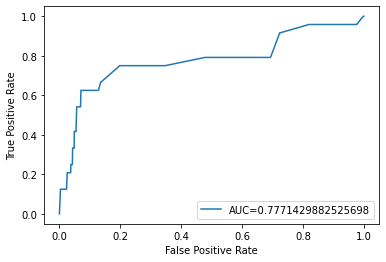

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

data = pd.read_csv("datafinal.csv")
correlation = data.corr()

#transform the categorical into numeric
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2,"CASH_IN": 3, "TRANSFER": 4,"DEBIT": 5})
data["isFraud"] = data["isFraud"].map({0: "No Fraud", 1: "Fraud"})#string to integers
data.drop(['nameOrig','nameDest'],axis=1,inplace=True)
X=data.drop('isFraud',axis=1)
y=data['isFraud']

for i in range(1,7):
    max_X=max(X.iloc[:,i])
    min_X=min(X.iloc[:,i])
    X.iloc[:,i]=(X.iloc[:,i]-min_X)/(max_X-min_X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_cv, X_test_new=np.split(X_test, 2)
Y_cv , Y_test_new=np.split(y_test, 2)

#To convert to integers(values not strings)
y_train_new=np.zeros(len(y_train))
for i in range (len(y_train)):
    if y_train.iloc[i] == 'Fraud':
        y_train_new[i] =1  
        
y_train_new=pd.DataFrame(y_train_new)
Y_cv_new=np.zeros(len(Y_cv))
for i in range (len(Y_cv)):
    if Y_cv.iloc[i] == 'Fraud':
        Y_cv_new[i] =1  
        
Y_test_new_1=np.zeros(len(Y_cv))
for i in range (len(Y_test_new)):
    if Y_test_new.iloc[i] == 'Fraud':
        Y_test_new_1[i] =1

def generateXvector(X):    #add coloumn of 1s in X (features)
    vectorX = np.c_[np.ones((len(X), 1)), X]
    return vectorX

def theta_init(X):      #generating random thetas
    theta = np.random.randn(X+1, 1)
    return theta

def sigmoid_function(X):     #hypothesis/output number between 0,1
    return 1/(1+math.e**(-X))

def Logistics_Regression(X,y,learningrate, iterations):
    y_new = y
    cost_lst = []
    vectorX = generateXvector(X)
    theta = theta_init(len(X.iloc[0,:]))
    m = len(X)
    for i in range(iterations):
        gradients = 2/m * vectorX.T.dot(sigmoid_function(vectorX.dot(theta)) - y_new)
        theta = theta - learningrate * gradients
        y_pred = sigmoid_function(vectorX.dot(theta))
        cost_value = - np.sum(np.dot(y_new.T,np.log(y_pred)+ np.dot((1-y_new).T,np.log(1-y_pred)))) /(len(y_pred))
        cost_lst.append(cost_value)     #append the costs
    return theta, cost_value

theta1, cost_value1=Logistics_Regression(X_train,y_train_new,0.03, 100)
def root_regularization(y_pred,y_test,theta):
    cost_reg=100
    best_lamda=0
    lamda=np.array([0.01,0.02,0.04,0.08,0.16,0.32,0.64,1.28,2.56,5.12,10.24])
    cost_lst = []
    m = len(X)
    N = len(y_test)
    for l in range(np.size(lamda)):
        term=(lamda[l]/2*N)*(np.sum(theta**2))
        cost_value = (- np.sum(np.dot(y_test.T,np.log(y_pred)+ np.dot((1-y_test).T,np.log(1-y_pred)))) /(len(y_pred)))+term
        cost_lst.append(cost_value)
        if cost_value<cost_reg:
            cost_reg=cost_value
            best_lamda=lamda[l]
    return best_lamda,cost_reg

def rmse(y_pred,y_test):
    cost_value = (- np.sum(np.dot(y_test.T,np.log(y_pred)+ np.dot((1-y_test).T,np.log(1-y_pred)))) /(len(y_pred)))
    return cost_value

cost_cv=100
theta1_cv=[]
for j in range(9):     #cross validation loop on the feautres
    vectorX=generateXvector(X_cv.iloc[:,0:j])
    theta2, cost_value1=Logistics_Regression(X_train.iloc[:,0:j],y_train_new,0.03, 100)
    y_pred = sigmoid_function(vectorX.dot(theta2))#hypothesis using best thetas
    best_lamda,cost_reg=root_regularization(y_pred,Y_cv_new,theta2)
    if cost_value1<cost_cv:
        cost_cv=cost_value1
        theta1_cv=theta2
    if cost_reg<cost_cv:
        cost_cv=cost_reg
        theta1_cv=theta2  #thetas for best hypothesis
        
y_pred_test=sigmoid_function(np.dot(X_test_new.iloc[:,0:np.size(theta1_cv)], theta1_cv))
cost_Y_test=rmse(y_pred_test,Y_test_new_1)
cost_test_reg=rmse(y_pred_test,Y_test_new_1)+(best_lamda/2*len(Y_cv))*(np.sum(theta1_cv**2))

#K-fold
skfolds = KFold(n_splits=10)    #shuffle
splits = skfolds.split(X, y)
for i, (train_index, test_index) in enumerate(splits): #split and shuffle the data   
  x_train = X.iloc[train_index]
  y_train = y.iloc[train_index]
  x_test  = X.iloc[test_index]
  y_test  = y.iloc[test_index]
  clf = LogisticRegression()
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  accuracy = np.mean(y_pred == y_test)
  print(accuracy,'accuracy per iteration')
  
#stratified sampling
skfolds_1 = StratifiedKFold(n_splits=9)
splits_1 = skfolds_1.split(X, y)
for i, (train_index, test_index) in enumerate(splits_1): #split and shuffle the data 
  x_train = X.iloc[train_index]
  y_train = y.iloc[train_index]
  x_test  = X.iloc[test_index]
  y_test  = y.iloc[test_index]
  clf_1 = LogisticRegression()
  clf_1.fit(x_train, y_train)
  y_pred_1 = clf_1.predict(x_test)
  accuracy = np.mean(y_pred_1 == y_test)
  print("Accuracy: %.4f"%accuracy)
  print("[SPLIT %d]"%(i+1))

#conv matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

print(sklearn.metrics.confusion_matrix(Y_test_new_1,np.round((y_pred_test))))
print(accuracy_score(Y_test_new_1, np.round((y_pred_test))) )
fpr, tpr, _ = metrics.roc_curve(Y_test_new_1,  y_pred_test)#represents the relation between TP and FP
auc = metrics.roc_auc_score(Y_test_new_1, y_pred_test)

#create ROC curve
plt.figure()
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()